In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import numpy as np
import os
import pandas as pd

## Reading the CSV and images

In [8]:
# Load multiple scan images from directory
dataset_dir = '../dataset/jpeg/'
image_list=[]
folder_name_list = os.listdir(dataset_dir)[:100]
for foldername in folder_name_list:
    image_dir = dataset_dir + foldername
    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg'):
            image = cv2.imread(os.path.join(image_dir, filename))
            if image is not None:
                image_list.append(image)


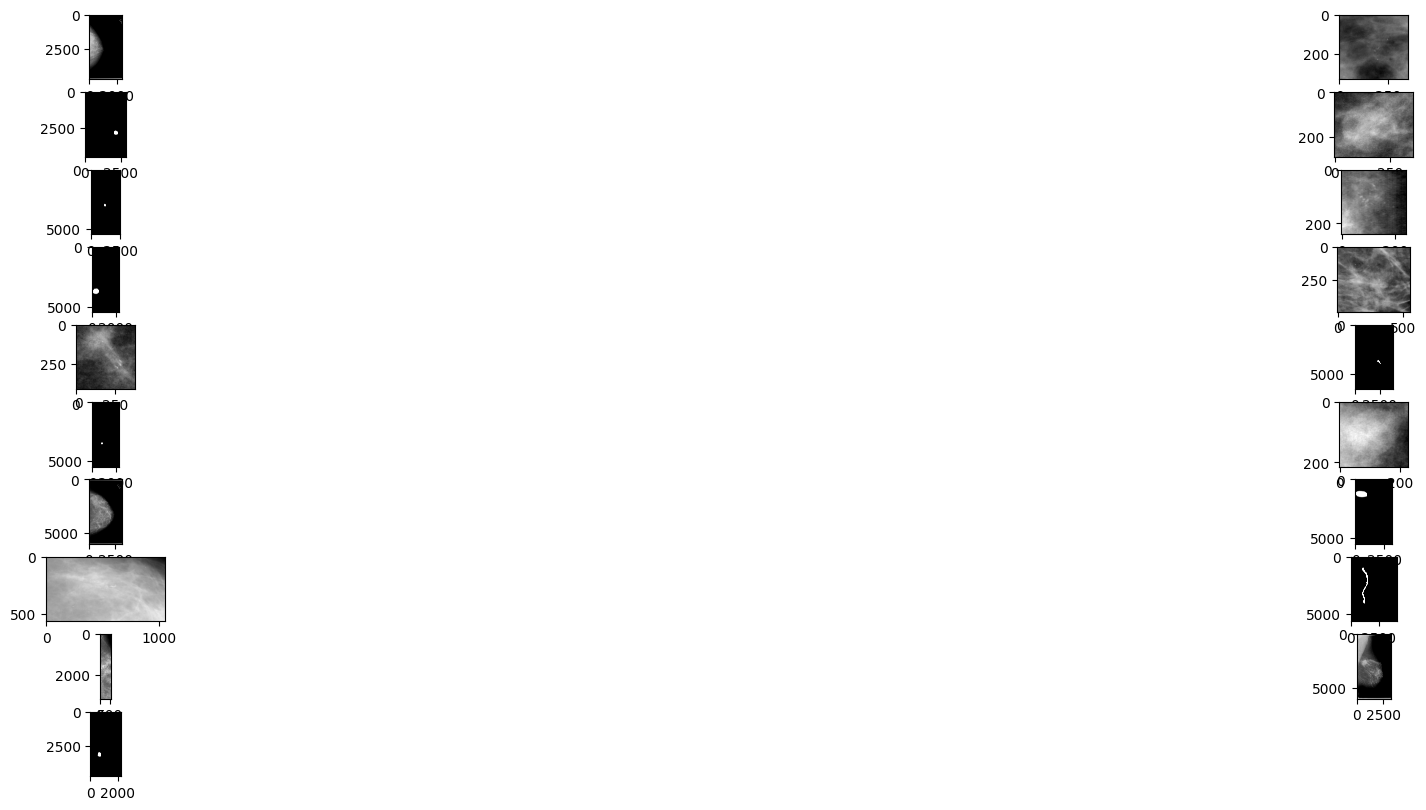

In [21]:
fig = plt.figure(figsize=(30, 30))
columns = 4
rows = 30
for i in range(1, len(image_list[:20])):
    img = image_list[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()